# 0. Operational

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import sys
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

sys.path.append(str(Path('..').resolve()))
from src.data_loader import load_data
from src.feature_engineering import FeatureEngineering, DataPrep
from src.train_test_split import TimeSeriesSplit
from src.models import LogisticTrainer, KNNTrainer, DecisionTreeTrainer, XGBTrainer

In [9]:
# Load the file into a DataFrame
file_path = '../data/indexData.csv'
df = pd.read_csv(file_path)

# 1. EDA Visualizations
## 1.1. Missing and Zero Values Visualization

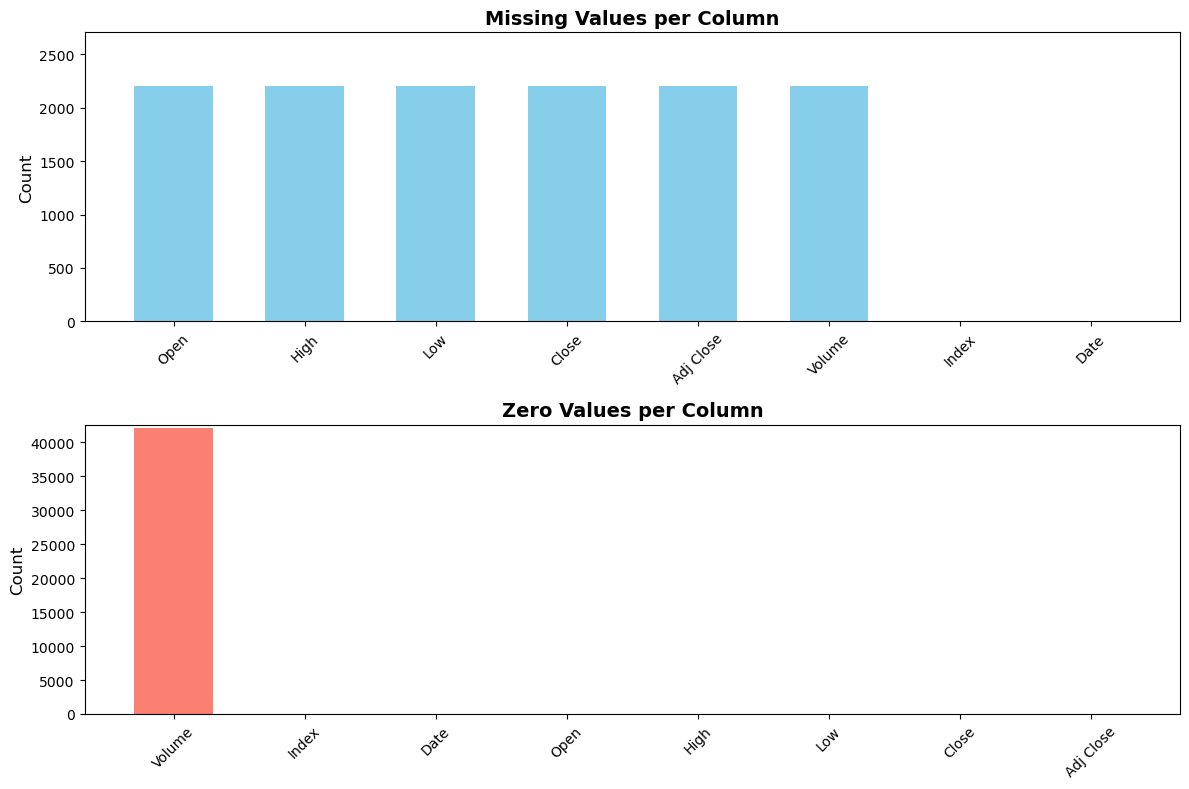

In [10]:
import matplotlib.pyplot as plt

# Create a 2-row figure
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # Adjusted figsize for better proportions
plt.subplots_adjust(hspace=0.4)

# Missing values (NaN)
missing_counts = df.isna().sum().sort_values(ascending=False)
axes[0].bar(missing_counts.index, missing_counts.values, color='skyblue', width=0.6)  # Bar width adjusted
axes[0].set_title('Missing Values per Column', fontsize=14, weight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Zero values
zero_counts = (df == 0).sum().sort_values(ascending=False)
axes[1].bar(zero_counts.index, zero_counts.values, color='salmon', width=0.6)  # Consistent bar width
axes[1].set_title('Zero Values per Column', fontsize=14, weight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Set a consistent y-axis limit if relevant
axes[0].set_ylim(0, missing_counts.max() + 500)  # Add some padding
axes[1].set_ylim(0, zero_counts.max() + 500) 

plt.tight_layout()
plt.show()


## 1.3. Distribution of Open, Close, High, and Low Values

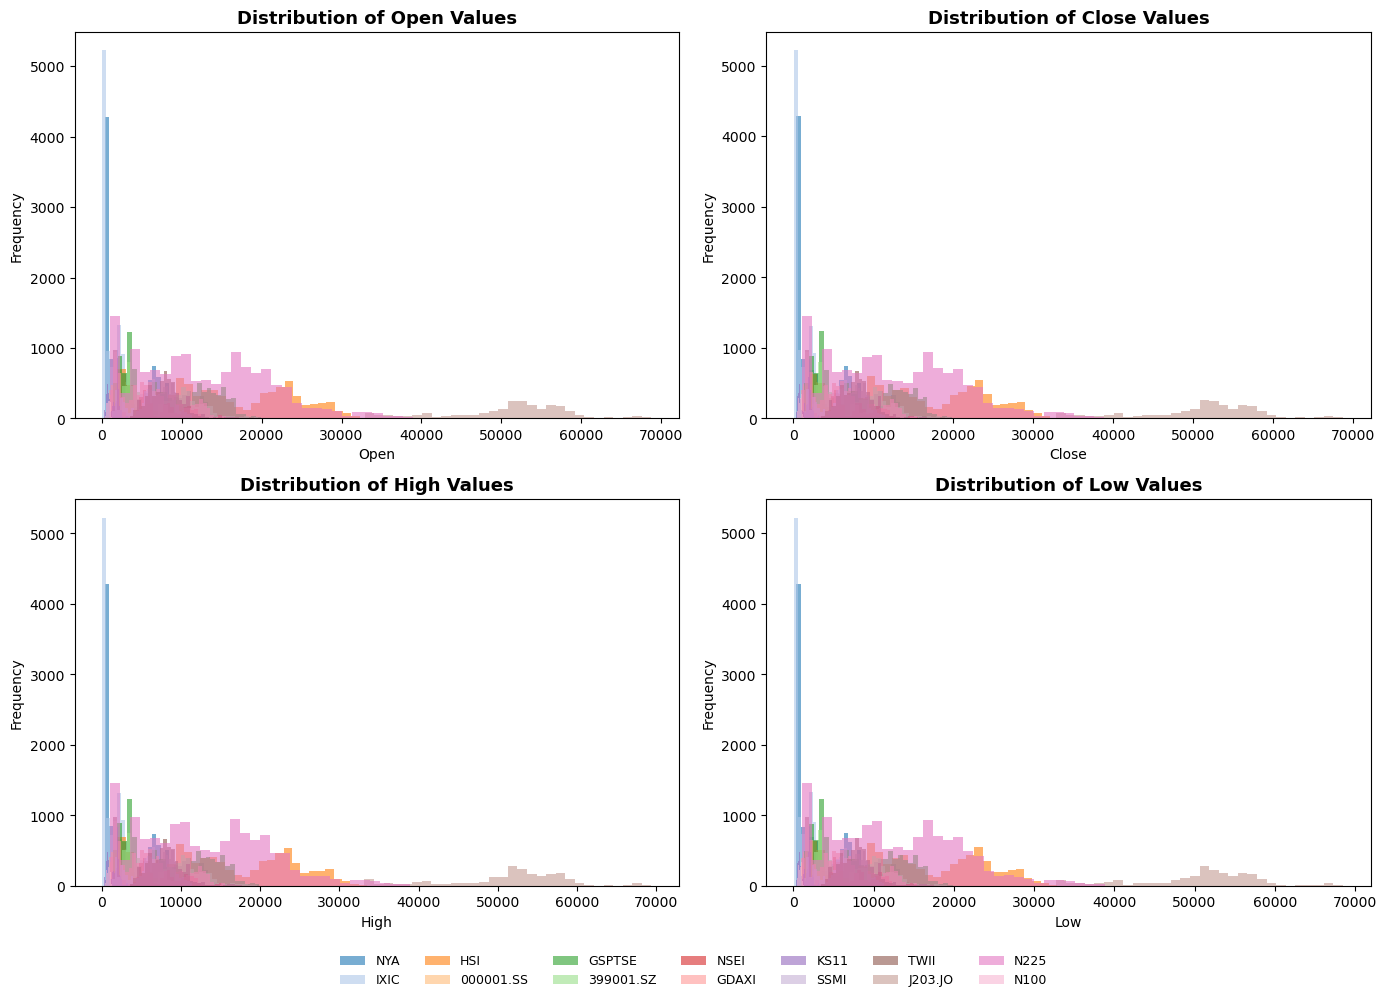

In [11]:
# Visualization Initialization
index_col = 'Index' 
unique_indices = df[index_col].unique()

# Generate a distinct color for each index (14 total)
colors = sns.color_palette("tab20", len(unique_indices))
color_map = dict(zip(unique_indices, colors))

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
columns = ['Open', 'Close', 'High', 'Low']

for ax, col in zip(axes, columns):
    for idx in unique_indices:
        subset = df[df[index_col] == idx]
        ax.hist(subset[col].dropna(), bins=30, color=color_map[idx], alpha=0.6, label=idx)
    ax.set_title(f'Distribution of {col} Values', fontsize=13, weight='bold')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Frequency')

# Add a single legend below all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=7, frameon=False, fontsize=9)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # gap to fit legend
plt.show()


## 1.4. Distribution of Volume Values

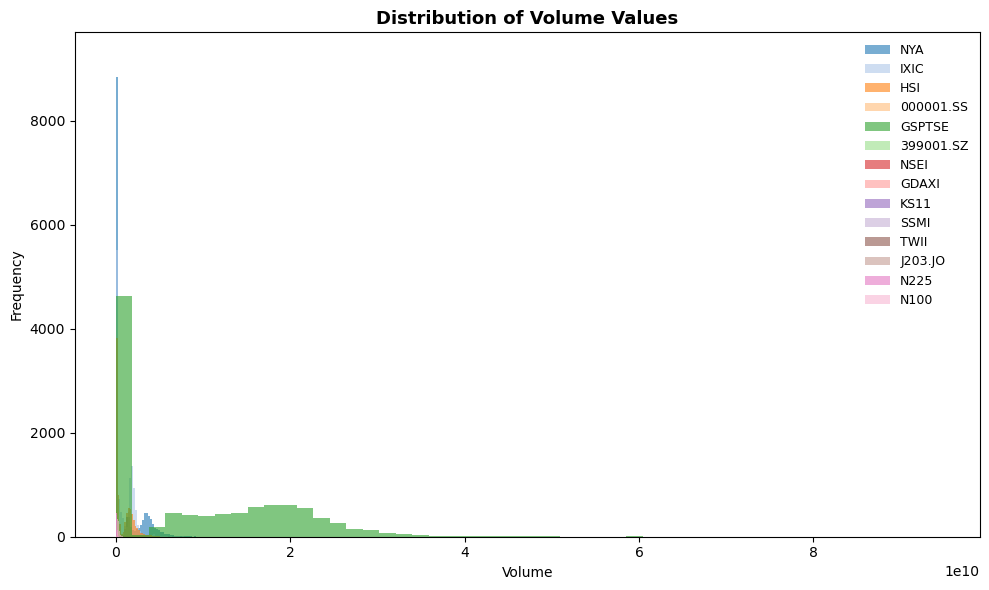

In [12]:
# Visualize Volume distribution separately
plt.figure(figsize=(10, 6))

# Plot Volume distribution for each index
for idx in unique_indices:
    subset = df[df[index_col] == idx]
    plt.hist(subset['Volume'].dropna(), bins=50, color=color_map[idx], alpha=0.6, label=idx)
plt.title('Distribution of Volume Values', fontsize=13, weight='bold')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend(loc='upper right', frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

In [13]:
# Summary for Zero Volume
zero_volume = df[df['Volume'] == 0]
print(f'Total records with zero Volume: {len(zero_volume)}','\n')

# Summary for Zero Volume per Index
zero_volume_per_index = zero_volume[index_col].value_counts()
print("Zero Volume per Index:")
print(zero_volume_per_index)


Total records with zero Volume: 42093 

Zero Volume per Index:
Index
N225         9239
NYA          8832
HSI          3602
IXIC         3457
SSMI         3039
GDAXI        2974
J203.JO      2346
N100         1657
399001.SZ    1570
000001.SS    1361
TWII         1353
GSPTSE       1343
NSEI         1320
Name: count, dtype: int64


# Data Cleaning
TBA

## Logisitic Regression

In [2]:
# Prepare data using DataPrep component
prep = DataPrep(file_path='../data/indexData.csv')
df_eng, features = prep.prepare(stock_index_pattern='Euronext')

# Setup time-series split (reused across all trainers)
ts_split = TimeSeriesSplit(test_size=0.2)

# Train LogisticRegression model using the trainer component
trainer_lr = LogisticTrainer(features=features, solver='liblinear')
X_train, X_test, y_train, y_test = trainer_lr.prepare_data(df_eng, ts_split)
trainer_lr.fit(X_train, y_train)

Loading data from ../data/indexData.csv...
Found 3817 rows for Euronext
Selected 14 features: ['pct_change', 'sma_5', 'sma_20', 'ema_5', 'ema_20', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'lag_1', 'lag_2', 'lag_3', 'dow', 'month']
Dataset size: 3797, Classes: 2, Positive: 2022
Found 3817 rows for Euronext
Selected 14 features: ['pct_change', 'sma_5', 'sma_20', 'ema_5', 'ema_20', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'lag_1', 'lag_2', 'lag_3', 'dow', 'month']
Dataset size: 3797, Classes: 2, Positive: 2022


In [ ]:
# Evaluate model
metrics = trainer_lr.evaluate(X_test, y_test)
print(f'Accuracy: {metrics["accuracy"]:.4f}')
print('Classification report:\n', metrics['classification_report'])
print('Confusion matrix:\n', metrics['confusion_matrix'])
if metrics['roc_auc'] is not None:
    print(f'ROC AUC: {metrics["roc_auc"]:.4f}')

# Save model
trainer_lr.save(str(Path('..') / 'models' / 'logistic_model_euronext.pkl'))
print(f'Model saved to models/logistic_model_euronext.pkl')


Accuracy: 0.5434
Classification report:
               precision    recall  f1-score   support

           0     0.3939    0.0382    0.0697       340
           1     0.5502    0.9524    0.6975       420

    accuracy                         0.5434       760
   macro avg     0.4721    0.4953    0.3836       760
weighted avg     0.4803    0.5434    0.4166       760

Confusion matrix:
 [[ 13 327]
 [ 20 400]]
ROC AUC: 0.5088
Model saved to ..\models\logistic_model_euronext.pkl


## KNN

In [4]:
# KNN model using the trainer component
trainer_knn = KNNTrainer(features=features, n_neighbors=5)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = trainer_knn.prepare_data(df_eng, ts_split)
trainer_knn.fit(X_train_knn, y_train_knn)

In [ ]:
# Evaluate KNN model
metrics_knn = trainer_knn.evaluate(X_test_knn, y_test_knn)
print('Accuracy:', round(metrics_knn['accuracy'], 4))
print('Classification report:\n', metrics_knn['classification_report'])
print('Confusion matrix:\n', metrics_knn['confusion_matrix'])

# Save model
trainer_knn.save(str(Path('..') / 'models' / 'knn_model_euronext.pkl'))
print(f'Model saved to models/knn_model_euronext.pkl')


Accuracy: 0.4697
Classification report:
               precision    recall  f1-score   support

           0     0.4194    0.4824    0.4487       340
           1     0.5230    0.4595    0.4892       420

    accuracy                         0.4697       760
   macro avg     0.4712    0.4709    0.4690       760
weighted avg     0.4767    0.4697    0.4711       760

Confusion matrix:
 [[164 176]
 [227 193]]
Model saved to ..\models\knn_model_euronext.pkl


## Decision Tree

In [6]:
# Define numerical and categorical features for Decision Tree
numeric_features = [
    'pct_change','sma_5','sma_20','ema_5','ema_20','rsi',
    'macd','macd_signal','macd_hist','lag_1','lag_2','lag_3'
]
categorical_features = ['dow', 'month']

available_numeric = [f for f in numeric_features if f in df_eng.columns]
available_categorical = [f for f in categorical_features if f in df_eng.columns]

dt_features = available_numeric + available_categorical

print(f"Numerical Features: {available_numeric}\n")
print(f"Categorical Features: {available_categorical}\n")

# Decision Tree model using the trainer component
trainer_dt = DecisionTreeTrainer(
    features=dt_features,
    numeric_features=available_numeric,
    categorical_features=available_categorical,
    max_depth=10
)
X_train_dt, X_test_dt, y_train_dt, y_test_dt = trainer_dt.prepare_data(df_eng, ts_split)
trainer_dt.fit(X_train_dt, y_train_dt)

Numerical Features: ['pct_change', 'sma_5', 'sma_20', 'ema_5', 'ema_20', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'lag_1', 'lag_2', 'lag_3']

Categorical Features: ['dow', 'month']



In [ ]:
# Evaluate Decision Tree model
metrics_dt = trainer_dt.evaluate(X_test_dt, y_test_dt)
print('Accuracy:', round(metrics_dt['accuracy'], 4))
print('Classification report:\n', metrics_dt['classification_report'])
print('Confusion matrix:\n', metrics_dt['confusion_matrix'])

# Save model
trainer_dt.save(str(Path('..') / 'models' / 'decision_tree_model_euronext.pkl'))
print(f'Model saved to models/decision_tree_model_euronext.pkl')


Accuracy: 0.4618
Classification report:
               precision    recall  f1-score   support

           0     0.4203    0.5353    0.4709       340
           1     0.5168    0.4024    0.4525       420

    accuracy                         0.4618       760
   macro avg     0.4686    0.4688    0.4617       760
weighted avg     0.4737    0.4618    0.4607       760

Confusion matrix:
 [[182 158]
 [251 169]]
Model saved to ..\models\decision_tree_model_euronext.pkl


# XGBoost

In [8]:
# XGBoost model using the trainer component
trainer_xgb = XGBTrainer(features=features, n_estimators=100, max_depth=6, learning_rate=0.1)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = trainer_xgb.prepare_data(df_eng, ts_split)
trainer_xgb.fit(X_train_xgb, y_train_xgb)

c:\Users\markc\anaconda3\envs\dsi_participant\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:13:11] WARNING: D:\bld\xgboost-split_1737531311373\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Evaluate XGBoost model
metrics_xgb = trainer_xgb.evaluate(X_test_xgb, y_test_xgb)
print('Accuracy:', round(metrics_xgb['accuracy'], 4))
print('Classification report:\n', metrics_xgb['classification_report'])
print('Confusion matrix:\n', metrics_xgb['confusion_matrix'])
if metrics_xgb['roc_auc'] is not None:
    print(f'ROC AUC: {metrics_xgb["roc_auc"]:.4f}')

# Save model
trainer_xgb.save(str(Path('..') / 'models' / 'xgb_model_euronext.pkl'))
print(f'Model saved to models/xgb_model_euronext.pkl')


Accuracy: 0.4855
Classification report:
               precision    recall  f1-score   support

           0     0.4452    0.6088    0.5143       340
           1     0.5492    0.3857    0.4531       420

    accuracy                         0.4855       760
   macro avg     0.4972    0.4973    0.4837       760
weighted avg     0.5026    0.4855    0.4805       760

Confusion matrix:
 [[207 133]
 [258 162]]
ROC AUC: 0.4932
Model saved to ..\models\xgb_model_euronext.pkl
